In [1]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cred_data = pd.read_csv("datos/creditcard.csv")

In [3]:
cred_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
cred_data.shape

(284807, 31)

In [5]:
X_train = cred_data[cred_data['Class'] == 0].drop(columns=['Class']).values
X_train, X_val = train_test_split(X_train, 
                                   test_size=0.2, 
                                   random_state=42)

y_val = np.zeros(X_val.shape[0])
X_test = cred_data[cred_data['Class'] == 1].drop(columns=['Class']).values
y_test = np.ones(X_test.shape[0])
X_val, X_test, y_val, y_test = train_test_split(np.concatenate((X_val, X_test), axis=0), 
                                                np.concatenate((y_val, y_test), axis=0), 
                                                test_size=0.5,
                                                stratify=np.concatenate((y_val, y_test), axis=0), 
                                                random_state=42)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((227452, 30), (28677, 30), (28678, 30))

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float16)
X_val = scaler.transform(X_val).astype(np.float16)
X_test = scaler.transform(X_test).astype(np.float16)

In [8]:
features = X_train.shape[1]

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(256).shuffle(1024).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, X_val)).batch(256).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test)).batch(256).prefetch(tf.data.AUTOTUNE)

2026-01-28 00:42:19.635102: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-28 00:42:19.635119: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-28 00:42:19.635123: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-28 00:42:19.635151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-28 00:42:19.635161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
def create_autoencoder(features, units_1, units_2, activation):
    model = Sequential()
    model.add(Input(shape=(features,)))
    model.add(Dense(units_1, activation=activation))
    model.add(Dense(units_2, activation=activation))
    model.add(Dense(2, activation='linear'))
    model.add(Dense(units_2, activation=activation))
    model.add(Dense(units_1, activation=activation))
    model.add(Dense(features, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=5e-3), 
        loss='huber_loss',
        metrics=['mse']
    )

    return model

In [11]:
def build_model(hp, features):
    units_1 = hp.Int("units_1", 32, 64, step=16)
    units_2 = hp.Int("units_2", 4, 8, step=2)
    activation = hp.Choice("activation", ["tanh", "leaky_relu"])

    model = create_autoencoder(features, units_1, units_2, activation)

    return model
    

In [12]:
tuner = kt.Hyperband(
    hypermodel=lambda hp: build_model(hp, features),
    objective="val_mse",
    max_epochs=15,
    factor=10,
    directory="hyperband_dir",
    project_name="hyperband_project",
    overwrite=True,
    seed=42,
)

In [13]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        EarlyStopping(monitor='val_mse', patience=5),
    ],
    verbose=1,
)

Trial 19 Complete [00h 00m 58s]
val_mse: 0.8813039660453796

Best val_mse So Far: 0.8813039660453796
Total elapsed time: 00h 05m 46s


In [14]:
best_hps = tuner.get_best_hyperparameters(1)[0]
autoencoder = create_autoencoder(
    features,
    best_hps.get("units_1"),
    best_hps.get("units_2"),
    best_hps.get("activation"),
)

In [15]:
print(best_hps.values)

{'units_1': 64, 'units_2': 8, 'activation': 'leaky_relu', 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [16]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 dense_8 (Dense)             (None, 2)                 18        
                                                                 
 dense_9 (Dense)             (None, 8)                 24        
                                                                 
 dense_10 (Dense)            (None, 64)                576       
                                                                 
 dense_11 (Dense)            (None, 30)                1950      
                                                                 
Total params: 5072 (19.81 KB)
Trainable params: 5072 (

In [17]:
autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True),
    ],
    verbose=1,
)

Epoch 1/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2588 - mse: 0.8121 - val_loss: 0.2633 - val_mse: 0.9829
Epoch 2/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2398 - mse: 0.7632 - val_loss: 0.2540 - val_mse: 0.9590
Epoch 3/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2327 - mse: 0.7441 - val_loss: 0.2494 - val_mse: 0.9455
Epoch 4/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2292 - mse: 0.7346 - val_loss: 0.2480 - val_mse: 0.9438
Epoch 5/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2271 - mse: 0.7287 - val_loss: 0.2456 - val_mse: 0.9343
Epoch 6/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2244 - mse: 0.7180 - val_loss: 0.2416 - val_mse: 0.9203
Epoch 7/100
889/889 [==============================] - 4s 4ms/step - loss: 0.2225 - mse: 0.7004 - val_loss: 0.2406 - val_mse: 0.9013
Epoch 8/100
889/889 [==============================] - 4s 4ms/step - 

In [18]:
X_train_pred = autoencoder.predict(train_ds)
train_mae = np.mean(np.abs(X_train - X_train_pred), axis=1)

889/889 [==============================] - 1s 1ms/step


In [19]:
threshold = np.quantile(train_mae, 0.95)
threshold

1.2617485642433164

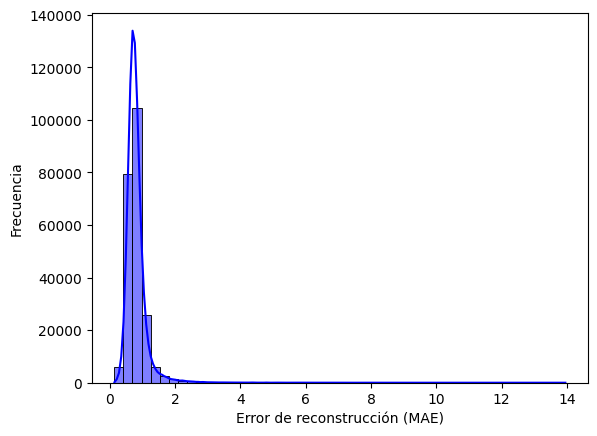

In [20]:
ax = sns.histplot(train_mae, bins=50, color='blue', alpha=0.5, kde=True)
ax.set_xlabel("Error de reconstrucción (MAE)")
ax.set_ylabel("Frecuencia")
plt.show()

In [21]:
X_test_pred = autoencoder.predict(test_ds)
test_mae = np.mean(np.abs(X_test - X_test_pred), axis=1)

113/113 [==============================] - 0s 1ms/step


In [22]:
y_pred = (test_mae > threshold).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     28432
         1.0       0.29      0.82      0.43       246

    accuracy                           0.98     28678
   macro avg       0.64      0.90      0.71     28678
weighted avg       0.99      0.98      0.99     28678

